# **Упражнение 3.1**

Прочитать пояснения и выполнить примеры в https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/master/code/chap03.ipynb

В примере с утечкой замените окно Хэмминга одним из окон, предоставляемых NumPy, и посмотрите, как они влияют на утечку См. [http://docs.scipy.org/doc/numpy/reference/routines.window.html](http://docs.scipy.org/doc/numpy/reference/routines.window.html).

**Ход работы**

По представленной ссылке была изучена работа примеров.

In [1]:
import os
!pip install wget
if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import SinSignal, Chirp
from thinkdsp import decorate, unbias, normalize, read_wave
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists('marcgascon-vocals.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap03/marcgascon-vocals.wav

if not os.path.exists('violin-glissando.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap03/violin-glissando.wav

Исследуем влияние различных окон на утечку

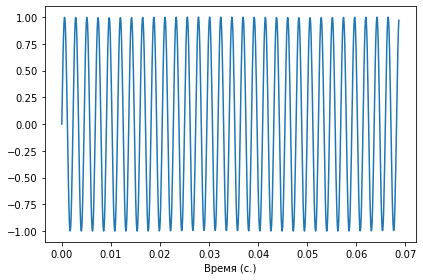

In [2]:
signal = SinSignal(freq=440)
wave = signal.make_wave(signal.period*30.25)
wave.plot()
decorate(xlabel='Время (с.)')

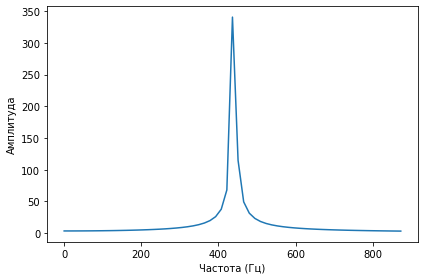

In [3]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда')

Без использования оконных функций можем наблюдать на спектре компоненты, размазанные в диапазоне от 240 до 640 Гц.
Используем различные оконные функции и сравним их.

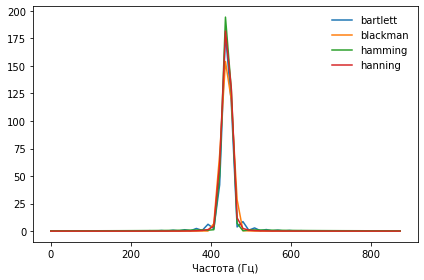

In [4]:
for fun in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(signal.period*30.25)
    wave.ys *= fun(len(wave.ys))
    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=fun.__name__)
decorate(xlabel='Частота (Гц)')

На рисунке видно, что используя различные оконные функции мы получаем различные варианты графиков.

# **Упражнение 3.2**

Напишите класс, называемый *SawtoothChirp*, расширяющий *Chirp* и переопределяющий *evaluate* для генерации пилообразного сигнала с линейно увеличивающейся (или уменьшающейся) частотой.

Подсказка: надо совместить функции *evaluate* и *Chirp* и *SawtoothSignal*.

Нарисуйте эскиз спектрограммы этого сигнала, а затем распечатайте её. Эффект биений должен быть очевиден, а если сигнал внимательно прослушать, то биения можно и услышать.

**Ход работы**

In [5]:
class SawtoothChirp(Chirp):
  
  def evaluate(self, ts):
    freqs = np.linspace(self.start, self.end, len(ts))
    dts = np.diff(ts, prepend=0)
    dphis = (2 * np.pi) * freqs * dts
    phases = np.cumsum(dphis)
    cycles = phases / (2 * np.pi)
    frac, _ = np.modf(cycles)
    ys = normalize(unbias(frac), self.amp)
    return ys

signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.make_audio()

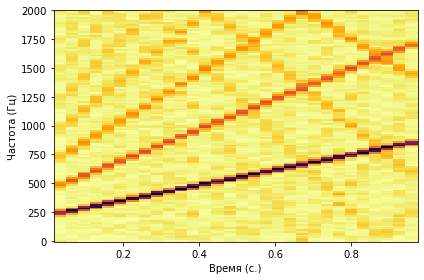

In [6]:
spectogram = wave.make_spectrogram(256)
spectogram.plot()
decorate(xlabel='Время (с.)', ylabel='Частота (Гц)')

# **Упражнение 3.3**

Создайте пилообразный чирп, меняющийся от 2500 до 3000 Гц, и на его основе сгенерируйте сигнал длительностью 1 с. и частотой кадров 20 кГц. Нарисуйте, каким примерно будет *Spectrum*. Затем распечатайте *Spectrum* и посмотрите, правы ли вы.

**Ход работы**

Так как основными частотатами здесь будут 2500-3000 Гц, то ожидается увидеть возвышение в их районе. Первая гармоника будет колебать в пределах 5000-6000 Гц, поэтому второе возвышение будет распологаться на этих частотах, но уже более низкое, чем первое. Третья гармоника будет в районе 7500-9000 Гц, соответственно третье возвышение, которое будет ниже всех предыдущих будет расположено здесь. Остальные гармоники будут накладываться друг на другах, поэтому мы увидим колебания на всех остальных частотах тоже.


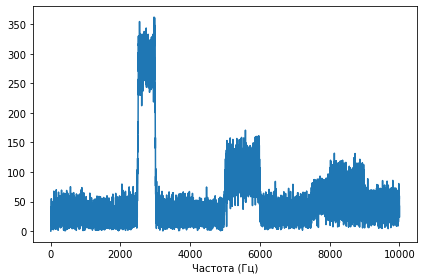

In [7]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_spectrum().plot()
decorate(xlabel='Частота (Гц)')

# **Упражение 3.4**

В музыкальной терминологии *глиссандо* - это нота, меняющаяся от одной высоты до другой, то есть своеобразный чирп.

Найдите или запишите звук глиссандо и распечатайте спектрограмму первых нескольких секунд.

**Ход работы**

Воспользуемся записью глиссандо скрипки.

In [8]:
wave = read_wave('violin-glissando.wav').segment(start=0, duration=5)
wave.make_audio()

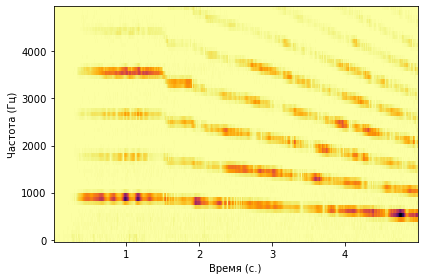

In [9]:
wave.make_spectrogram(512).plot(5000)
decorate(xlabel='Время (с.)', ylabel='Частота (Гц)')

# **Упражнение 3.5**

Тромбонист играет глиссандо, непрерывно дуя в мундштук и двигая кулису тромбона. При этом общая длина трубы меняется, а играемая нота обратно пропорциональна этой длине.

Если предположить, что музыкант двигает кулису с постоянной скоростью, как будет меняться во времени частота?

Напишите класс, называемый *TromboneGliss*, расширяющий *Chirp* и предоставляющий *evaluate*. Создайте сигнал, имитирующий глиссадо на тромбоне от C3 до F3, и обратно до C3. С3 - 262 Гц;
F3 - 349 Гц.

Напечатайте спектрограмму полученного сигнала. На что похоже глиссандо на тромбоне - на линейный или же экспоненциальный чирп?

**Ход работы**

Класс *TromboneGliss* представлен ниже.

In [10]:
class TromboneGliss(Chirp):
  
  def evaluate(self, ts):
    freqs = np.linspace(self.start, self.end, len(ts))
    dts = np.diff(ts, prepend=0)
    dphis = (np.pi * 2) * freqs * dts
    phases = np.cumsum(dphis)
    ys = self.amp * np.cos(phases)
    return ys

In [11]:
wave = TromboneGliss(349, 262).make_wave(duration=1) | TromboneGliss(262, 349).make_wave(duration=1)
wave.make_audio()

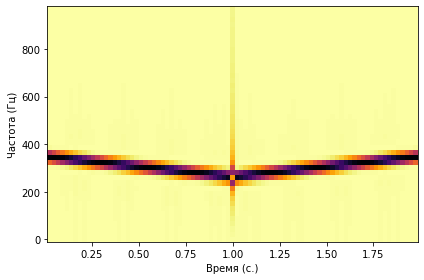

In [12]:
spectrogram = wave.make_spectrogram(512)
spectrogram.plot(1000)
decorate(xlabel='Время (с.)', ylabel='Частота (Гц)')

# **Упражнение 3.6**

Сделайте или найдите запись серии гласных звуков и посмотрите на спектрограмму. Сможете ли вы различить разные гласные?

**Ход работы**

In [13]:
wave = read_wave('marcgascon-vocals.wav')
wave.make_audio()

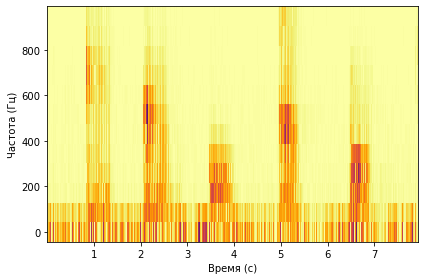

In [14]:
wave.make_spectrogram(512).plot(high=1000)
decorate(xlabel='Время (с)', ylabel='Частота (Гц)')

На спектограмме мы видим несколько пиков, которые немного искажены. Воспроизведя звук и параллельно анализируя спектограмму, мы можем понять, что пики относятся к гласным: "а", "э", "и", "о", "у".